#**Name: Iman Noor**
**Email: imannoor2002@gmail.com**

#**Movie Rating Prediction**


##**1. Introduction**
Build a model that predicts the rating of a movie based on
features like genre, director, and actors.

##**2. Problem Definition**
The goal is to analyze historical movie data and develop a model
that accurately estimates the rating given to a movie by users or
critics.

##**3. Features**
* **Name** - Movie Name.
* **Year** - Release year of the movie.
* **Duration** - Duration of the movie in minutes.
* **Genre** - Genre of the movie.
* **Rating** - Rating of the movie out of 10.
* **Votes** - Total number of votes.
* **Director** - Name of director.
* **Actor1** , **Actor2**, **Actor3** - Name of top 3 actors.

##**Preparing the tools**

In [248]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_log_error, mean_absolute_error, r2_score

##**Load the data**

In [249]:
# load data from drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [250]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/encoded-IMDb-Movies-India.csv')
df.shape

(15509, 10)

##**Exploratory data analysis (EDA)**

In [251]:
df.head()

,Name,Year,Duration,Genre,Rating,Votes,Director,Actor 1,Actor 2,Actor 3
0,,NaN,NaN,Drama,NaN,NaN,J.S. Randhawa,Manmauji,Birbal,Rajendra Bhatia
1,#Gadhvi (He thought he was Gandhi),-2019.0,109 min,Drama,7.0,8,Gaurav Bakshi,Rasika Dugal,Vivek Ghamande,Arvind Jangid
2,#Homecoming,-2021.0,90 min,"Drama, Musical",NaN,NaN,Soumyajit Majumdar,Sayani Gupta,Plabita Borthakur,Roy Angana
3,#Yaaram,-2019.0,110 min,"Comedy, Romance",4.4,35,Ovais Khan,Prateik,Ishita Raj,Siddhant Kapoor
4,...And Once Again,-2010.0,105 min,Drama,NaN,NaN,Amol Palekar,Rajat Kapoor,Rituparna Sengupta,Antara Mali


In [252]:
df.describe(include='all')

,Name,Year,Duration,Genre,Rating,Votes,Director,Actor 1,Actor 2,Actor 3
count,15509,14981.000000,7240,13632,7919.000000,7920,14984,13892,13125,12365
unique,13838,NaN,182,485,NaN,2034,5938,4718,4891,4820
top,Anjaam,NaN,120 min,Drama,NaN,8,Jayant Desai,Ashok Kumar,Rekha,Pran
freq,7,NaN,240,2780,NaN,227,58,158,83,91
mean,NaN,-1987.012215,NaN,NaN,5.841621,NaN,NaN,NaN,NaN,NaN
std,NaN,25.416689,NaN,NaN,1.381777,NaN,NaN,NaN,NaN,NaN
min,NaN,-2022.000000,NaN,NaN,1.100000,NaN,NaN,NaN,NaN,NaN
25%,NaN,-2009.000000,NaN,NaN,4.900000,NaN,NaN,NaN,NaN,NaN
50%,NaN,-1991.000000,NaN,NaN,6.000000,NaN,NaN,NaN,NaN,NaN
75%,NaN,-1968.000000,NaN,NaN,6.800000,NaN,NaN,NaN,NaN,NaN


In [253]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15509 entries, 0 to 15508
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Name      15509 non-null  object 
 1   Year      14981 non-null  float64
 2   Duration  7240 non-null   object 
 3   Genre     13632 non-null  object 
 4   Rating    7919 non-null   float64
 5   Votes     7920 non-null   object 
 6   Director  14984 non-null  object 
 7   Actor 1   13892 non-null  object 
 8   Actor 2   13125 non-null  object 
 9   Actor 3   12365 non-null  object 
dtypes: float64(2), object(8)
memory usage: 1.2+ MB


In [254]:
df.isna().sum()

Name           0
Year         528
Duration    8269
Genre       1877
Rating      7590
Votes       7589
Director     525
Actor 1     1617
Actor 2     2384
Actor 3     3144
dtype: int64

In [255]:
# Check missing data
df.isnull().sum()/len(df)

Name        0.000000
Year        0.034045
Duration    0.533174
Genre       0.121027
Rating      0.489393
Votes       0.489329
Director    0.033851
Actor 1     0.104262
Actor 2     0.153717
Actor 3     0.202721
dtype: float64

In [256]:
df.duplicated(subset='Name').value_counts()

False    13838
True      1671
dtype: int64

In [257]:
df.drop_duplicates(subset='Name', inplace=True)
df.duplicated(subset='Name').value_counts()

False    13838
dtype: int64

In [258]:
df.drop(df.index[0], inplace=True)
df.reset_index(drop=True, inplace=True)

In [259]:
df['Year'] = df['Year'].astype(str).str.replace('-', '').astype(float)
df['Duration'] = df['Duration'].str.replace('min', '')

# Convert non-empty strings to integers
df['Duration'] = pd.to_numeric(df['Duration'], errors='coerce')
df['Votes'] = pd.to_numeric(df['Votes'], errors='coerce')

# removing extra spaces
df['Name'] = df['Name'].str.strip().str.replace('#', '')

In [260]:
# check for which numeric columns have null values
for label, content in df.items():
  if pd.api.types.is_numeric_dtype(content):
    if pd.isnull(content).sum():
      print(label)

Year
Duration
Rating
Votes


In [261]:
# check for which non-numeric columns have null values
for label, content in df.items():
  if not pd.api.types.is_numeric_dtype(content):
    if pd.isnull(content).sum():
      print(label)

Genre
Director
Actor 1
Actor 2
Actor 3


In [262]:
# dropping the missing values from year and genre
for label in ['Year', 'Genre']:
  if label in df.columns:
    if label in df.columns:
        df.dropna(subset=[label], inplace=True)

In [263]:
# filling column with the median
for label in ['Duration', 'Votes']:
    if pd.api.types.is_numeric_dtype(df[label]):
        df[label].fillna(df[label].median(), inplace=True)

df['Rating'].fillna(df['Rating'].mode().max(), inplace=True)

In [264]:
# checking if there is any null numeric and non-numeric values
for label, content in df.items():
  if pd.api.types.is_numeric_dtype(content) and not pd.api.types.is_numeric_dtype(content):
    if pd.isnull(content).sum():
      print(label) # the output will be nothing if there is no null value

In [265]:
df.head()

,Name,Year,Duration,Genre,Rating,Votes,Director,Actor 1,Actor 2,Actor 3
0,Gadhvi (He thought he was Gandhi),2019.0,109.0,Drama,7.0,8.0,Gaurav Bakshi,Rasika Dugal,Vivek Ghamande,Arvind Jangid
1,Homecoming,2021.0,90.0,"Drama, Musical",6.2,37.0,Soumyajit Majumdar,Sayani Gupta,Plabita Borthakur,Roy Angana
2,Yaaram,2019.0,110.0,"Comedy, Romance",4.4,35.0,Ovais Khan,Prateik,Ishita Raj,Siddhant Kapoor
3,...And Once Again,2010.0,105.0,Drama,6.2,37.0,Amol Palekar,Rajat Kapoor,Rituparna Sengupta,Antara Mali
4,...Aur Pyaar Ho Gaya,1997.0,147.0,"Comedy, Drama, Musical",4.7,827.0,Rahul Rawail,Bobby Deol,Aishwarya Rai Bachchan,Shammi Kapoor


In [266]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11783 entries, 0 to 13836
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Name      11783 non-null  object 
 1   Year      11783 non-null  float64
 2   Duration  11783 non-null  float64
 3   Genre     11783 non-null  object 
 4   Rating    11783 non-null  float64
 5   Votes     11783 non-null  float64
 6   Director  11357 non-null  object 
 7   Actor 1   10782 non-null  object 
 8   Actor 2   10386 non-null  object 
 9   Actor 3   9924 non-null   object 
dtypes: float64(4), object(6)
memory usage: 1012.6+ KB


##**Data Visualization**

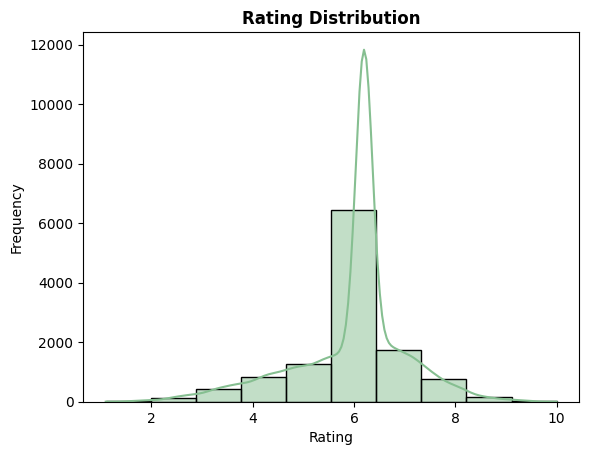

In [267]:
sns.histplot(data=df, x='Rating', bins=10, kde=True, color='#86bf91')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.title('Rating Distribution', weight='bold')
plt.show();

###**Best Rated Year Movie**

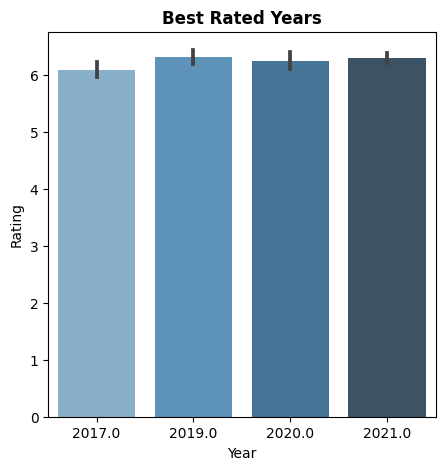

In [268]:
df_sorted = df.sort_values(by='Rating', ascending=False)
best_rate_year = df_sorted.head(5)['Year']
best_rate = df[df['Year'].isin(best_rate_year)][['Year', 'Rating']]
fig = plt.figure(figsize=(5,5))
sns.barplot(x='Year', y='Rating', data=best_rate, palette='Blues_d')
plt.xlabel('Year')
plt.ylabel('Rating')
plt.title('Best Rated Years', weight='bold')
plt.show();

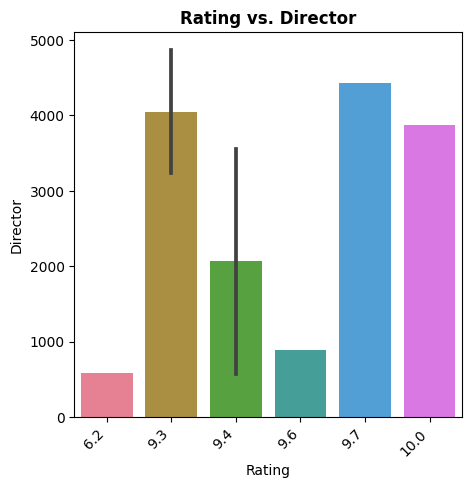

In [298]:
df_sort = df.sort_values(by='Rating', ascending=False)
top_movie = df_sort.head(10)['Director']
best_rate = df[df['Director'].isin(top_movie)][['Director', 'Rating']]
fig = plt.figure(figsize=(5,5))
sns.barplot(y='Director', x='Rating', data=best_rate, palette='husl')
plt.ylabel('Director')
plt.xlabel('Rating')
plt.title('Rating vs. Director', weight='bold')
plt.xticks(rotation=45, ha='right')
plt.show();

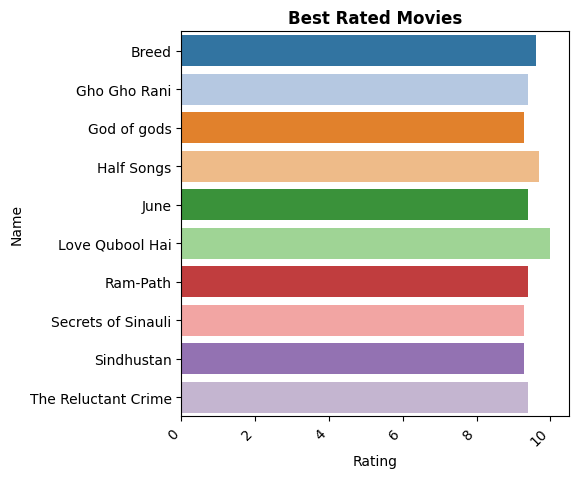

In [269]:
dataf = df.set_index('Year')
dataf.drop(index=2021, inplace=True)

df_sort = df.sort_values(by='Rating', ascending=False)
top_movie = df_sort.head(10)['Name']
best_rate = df[df['Name'].isin(top_movie)][['Name', 'Rating']]
fig = plt.figure(figsize=(5,5))
sns.barplot(y='Name', x='Rating', data=best_rate, palette='tab20')
plt.ylabel('Name')
plt.xlabel('Rating')
plt.title('Best Rated Movies', weight='bold')
plt.xticks(rotation=45, ha='right')
plt.show();

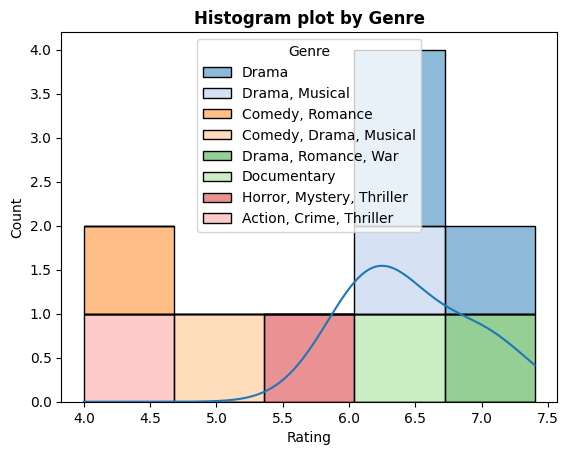

In [270]:
sns.histplot(data=df[:10], x='Rating', hue='Genre', multiple='stack', kde=True, palette='tab20')
plt.title('Histogram plot by Genre', weight='bold')
plt.show()

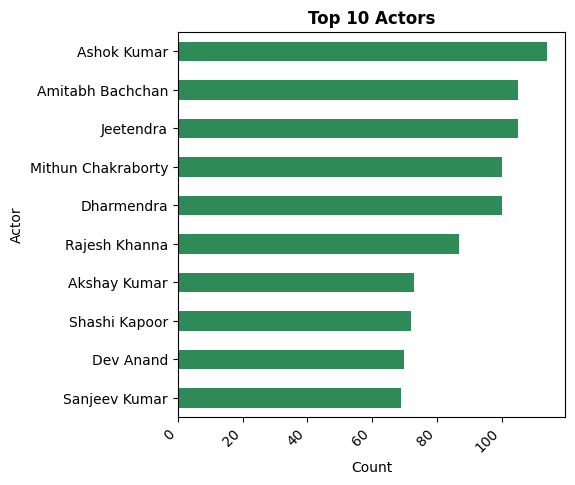

In [271]:
df['Actors'] = pd.concat([df['Actor 1'], df['Actor 2'], df['Actor 3']], ignore_index=True)
freq_actor = df['Actors'].value_counts().sort_values(ascending=False).head(10)
fig = plt.figure(figsize=(5,5))
freq_actor.sort_values().plot(kind='barh', color='seagreen')
plt.ylabel('Actor')
plt.xlabel('Count')
plt.title('Top 10 Actors', weight='bold')
plt.xticks(rotation=45, ha='right')
plt.show();

##**Preprocessing the data**

In [272]:
# fill non-numeric columns
for label, content in df.items():
  if not pd.api.types.is_numeric_dtype(content):
    df[label] = pd.Categorical(content).codes+1

In [273]:
df.head()

,Name,Year,Duration,Genre,Rating,Votes,Director,Actor 1,Actor 2,Actor 3,Actors
0,3663,2019.0,109.0,287,7.0,8.0,1344,2829,4149,472,2876
1,4375,2021.0,90.0,336,6.2,37.0,4405,3205,2472,2995,3262
2,11511,2019.0,110.0,218,4.4,35.0,2850,2516,1291,3498,2556
3,4,2010.0,105.0,287,6.2,37.0,334,2680,2995,361,2723
4,5,1997.0,147.0,188,4.7,827.0,3274,782,105,3333,777


##**Modelling**
* `Random Forest Regressor`

In [274]:
# instantiate model
model = RandomForestRegressor(n_jobs=-1,
                              random_state=42)

# fit the model
model.fit(df.drop("Rating", axis=1), df["Rating"])

RandomForestRegressor(n_jobs=-1, random_state=42)

In [275]:
model.score(df.drop("Rating", axis=1), df["Rating"])

0.9020853398590661

###**Splitting data into train/validation sets**

In [276]:
df.Year

0        2019.0
1        2021.0
2        2019.0
3        2010.0
4        1997.0
          ...  
13832    1988.0
13833    1999.0
13834    2005.0
13835    1988.0
13836    1998.0
Name: Year, Length: 11783, dtype: float64

In [277]:
df.Year.value_counts()

2019.0    386
2021.0    371
2018.0    353
2017.0    342
2020.0    303
         ... 
1934.0      9
1932.0      7
1931.0      6
1928.0      1
1917.0      1
Name: Year, Length: 94, dtype: int64

In [278]:
df_val = df[df.Year == 2007]
df_train = df[df.Year != 2007]

len(df_val), len(df_train)

(170, 11613)

In [279]:
X_train, y_train = df_train.drop('Rating', axis=1), df_train.Rating
x_valid, y_valid = df_val.drop('Rating', axis=1), df_val.Rating
X_train.shape, y_train.shape, x_valid.shape, y_valid.shape



((11613, 10), (11613,), (170, 10), (170,))

In [280]:
y_train

0        7.0
1        6.2
2        4.4
3        6.2
4        4.7
        ... 
13832    4.6
13833    4.5
13834    6.2
13835    6.2
13836    6.2
Name: Rating, Length: 11613, dtype: float64

###**Evaluation function**

In [281]:
def rmsle(y_test, y_preds):
  return np.sqrt(mean_squared_log_error(y_test, y_preds))
def show_scores(model):
  train_preds = model.predict(X_train)
  val_preds = model.predict(x_valid)
  scores={'Training MAE': mean_absolute_error(y_train, train_preds),
          'Valid MAE': mean_absolute_error(y_valid, val_preds),
          'Training RMSLE': rmsle(y_train, train_preds),
          'Valid RMSLE': rmsle(y_valid, val_preds),
          'Training R^2': r2_score(y_train, train_preds),
          'Validation R^2': r2_score(y_valid, val_preds)}
  return scores

##**Testing Model**

In [282]:
len(X_train)

11613

In [283]:
model = RandomForestRegressor(n_jobs=-1,
                              random_state=42,
                              max_samples=1000)

In [284]:
%%time
model.fit(X_train, y_train)

CPU times: user 1.39 s, sys: 21.4 ms, total: 1.41 s
Wall time: 790 ms


RandomForestRegressor(max_samples=1000, n_jobs=-1, random_state=42)

In [285]:
show_scores(model)

{'Training MAE': 0.5244587961766987,
 'Valid MAE': 0.9538705882352942,
 'Training RMSLE': 0.13756568581226242,
 'Valid RMSLE': 0.216353633691279,
 'Training R^2': 0.3950060699161382,
 'Validation R^2': 0.20356113529549702}

###**Hyperparameter tuning**

In [286]:
grid = {'n_estimators': np.arange(10, 100, 10),
        'max_depth': [None, 3, 5, 10],
        'min_samples_split': np.arange(2, 20, 2),
        'min_samples_leaf': np.arange(1, 20, 2),
        'max_features': [0.5, 1, 'sqrt', 'auto'],
        'max_samples': [1000]}
rs_model = RandomizedSearchCV(RandomForestRegressor(n_jobs=-1,
                                                    random_state=42),
                              param_distributions=grid,
                              n_iter=2,
                              cv=5,
                              verbose=True)
rs_model.fit(X_train, y_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


RandomizedSearchCV(cv=5,
                   estimator=RandomForestRegressor(n_jobs=-1, random_state=42),
                   n_iter=2,
                   param_distributions={'max_depth': [None, 3, 5, 10],
                                        'max_features': [0.5, 1, 'sqrt',
                                                         'auto'],
                                        'max_samples': [1000],
                                        'min_samples_leaf': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                                        'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
                                        'n_estimators': array([10, 20, 30, 40, 50, 60, 70, 80, 90])},
                   verbose=True)

In [287]:
rs_model.best_params_

{'n_estimators': 20,
 'min_samples_split': 8,
 'min_samples_leaf': 17,
 'max_samples': 1000,
 'max_features': 0.5,
 'max_depth': 3}

In [288]:
show_scores(rs_model)

{'Training MAE': 0.6463385149992925,
 'Valid MAE': 1.0282374157585907,
 'Training RMSLE': 0.1603869924298279,
 'Valid RMSLE': 0.2314804258094162,
 'Training R^2': 0.16661209438330948,
 'Validation R^2': 0.09146117834066203}

In [289]:
ideal_model = RandomForestRegressor(n_estimators=40,
                                    min_samples_leaf=1,
                                    min_samples_split=14,
                                    max_features=0.5,
                                    n_jobs=-1,
                                    max_samples=None,
                                    random_state=42)
ideal_model.fit(X_train, y_train)

RandomForestRegressor(max_features=0.5, min_samples_split=14, n_estimators=40,
                      n_jobs=-1, random_state=42)

In [290]:
show_scores(ideal_model)

{'Training MAE': 0.3558517188573816,
 'Valid MAE': 0.927633644492399,
 'Training RMSLE': 0.09751459748793082,
 'Valid RMSLE': 0.21537624303690595,
 'Training R^2': 0.7155918755890206,
 'Validation R^2': 0.21693844065931056}

###**Feature Importance**

In [291]:
ideal_model.feature_importances_

array([0.06169684, 0.17513628, 0.09082449, 0.12359639, 0.22082798,
       0.06261351, 0.07016752, 0.06861495, 0.07501789, 0.05150415])

In [292]:
def plot_features(columns, importances, n=20):
  df = (pd.DataFrame({'features': columns,
                      'feature_importances': importances})
       .sort_values('feature_importances', ascending=False)
       .reset_index(drop=True))
  fig, ax = plt.subplots()
  ax.barh(df['features'][:n], df['feature_importances'][:20])
  ax.set_ylabel('Features')
  ax.set_xlabel('Feature Importance')
  ax.invert_yaxis()

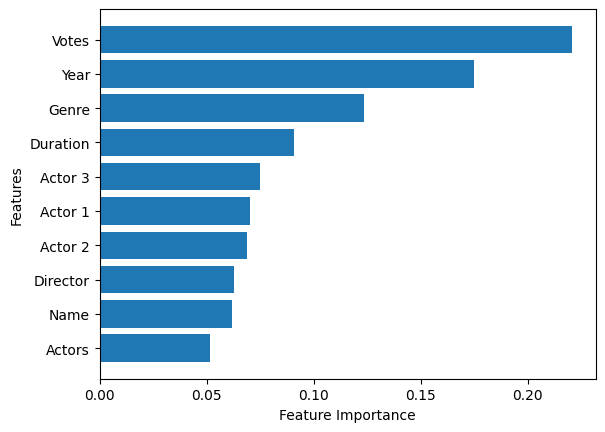

In [293]:
plot_features(X_train.columns, ideal_model.feature_importances_)

##**Conclusion**

In [294]:
# scores for ideal model (trained on all the data)
show_scores(ideal_model)

{'Training MAE': 0.3558517188573816,
 'Valid MAE': 0.9276336444923988,
 'Training RMSLE': 0.09751459748793082,
 'Valid RMSLE': 0.21537624303690595,
 'Training R^2': 0.7155918755890206,
 'Validation R^2': 0.21693844065931056}

In [295]:
# scores on rs_model (only trained on ~1000 examples)
show_scores(rs_model)

{'Training MAE': 0.6463385149992925,
 'Valid MAE': 1.0282374157585907,
 'Training RMSLE': 0.16038699242982793,
 'Valid RMSLE': 0.2314804258094162,
 'Training R^2': 0.16661209438330937,
 'Validation R^2': 0.09146117834066203}